In [ ]:
!pip install -q predibase datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 M

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
from predibase import Predibase, FinetuningConfig, DeploymentConfig

# Get a KEY from https://app.predibase.com/
from google.colab import userdata
api_token = ''
#api_token: str = userdata.get(PREDIBASE_API_KEY)
pb = Predibase(api_token=api_token)

Connected to Predibase as User(id=5ca711bf-c8e4-470d-93e9-6a9605e9983e, 
username=christopher.sastropranoto@gmail.com)

In [ ]:
import pandas as pd
# Need to process dataset
cultural = pd.read_csv('cultural.csv')
environment = pd.read_csv('environment.csv')
economic = pd.read_csv('economic.csv')
misc = pd.read_csv('misc.csv')
treatment = pd.read_csv('treatment.csv')

dataset = pd.concat([cultural, environment, economic, misc, treatment])

In [ ]:
# Preprocess Data

def preprocess_text(text: str) -> str:
  """Take in a text (review) and preprocess it.

  Attributes:
    text: The review.
  """

  PROMPT = f"""
  <|im_start|>system\nThe following is a review from locals or people from authority to tour companies. Please give it sentiment rating, from 1 to 10 of the review, where 1 denotes a completely negative sentiment, while 10 denotes a completely positive sentiment.<|im_end|>
  <|im_start|>passage\n {text}
  <|im_start|>rating\n
  """

  return PROMPT

review = 'Review'


In [ ]:
dataset['feedback'] = dataset['feedback'].apply(lambda x: preprocess_text(x))
dataset = dataset.rename(columns = {'sentiment': 'completion', 'feedback': 'prompt'})

dataset.head()

,prompt,completion
0,\n <|im_start|>system\nThe following is a rev...,1
1,\n <|im_start|>system\nThe following is a rev...,1
2,\n <|im_start|>system\nThe following is a rev...,1
3,\n <|im_start|>system\nThe following is a rev...,1
4,\n <|im_start|>system\nThe following is a rev...,1


In [ ]:
# Create the test set

from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.1, random_state=42)
train['split'] = 'train'
test['split'] = 'test'

train.to_csv('train.csv')
test.to_csv('test.csv')

In [ ]:
train.shape

(1028, 3)

In [ ]:
from tokenizers import Tokenizer
import csv
tokenizer = Tokenizer.from_pretrained("upstage/solar-1-mini-tokenizer")

def compute_cost(csv_file_name, price_per_million_tokens=0.5):
  """ Compute the cost of the dataset """

  total_num_of_tokens = 0
  with open(csv_file_name, 'r') as f:
    reader = csv.DictReader(f)
    # get all values
    values = [row['completion']+ " " + row['prompt'] for row in reader]
    for value in values:
      # tokenize
      enc = tokenizer.encode(value)
      num_of_tokens = len(enc.tokens)
      total_num_of_tokens += num_of_tokens


  return total_num_of_tokens / 1000000 * price_per_million_tokens

tokenizer.json:   0%|          | 0.00/3.31M [00:00<?, ?B/s]

In [ ]:
compute_cost('train.csv')

0.058555

In [ ]:
# Create an adapter repository
repo_name = "review-sentiment-model"
repo = pb.repos.create(name=repo_name, description="Review Sentiment Experiments GPT", exists_ok=True)
print(repo)

uuid='8e677b36-b363-4df7-93b3-12db9976a1ef' name='review-sentiment-model' description='Review Sentiment Experiments'


In [ ]:
# Start a fine-tuning job, blocks until training is finished

#train_dataset = pb.datasets.from_file('train.csv', name = "review_train_dataset_gpt")

adapter = pb.adapters.create(
    config=FinetuningConfig(
        base_model="solar-1-mini-chat-240612",
        epochs=3, # default: 3
        rank=16, # default: 16
    ),
    dataset="review_train_dataset_gpt", # Also accepts the dataset name as a string
    repo=repo,
    description="initial model with defaults"
)

Successfully requested finetuning of solar-1-mini-chat-240612 as `review-sentiment-model/3`. (Job UUID: 6076e07d-141b-4f31-b6c3-d453685c566b).

Watching progress of finetuning job 6076e07d-141b-4f31-b6c3-d453685c566b. This call will block until the job has finished. Canceling or terminating this call will NOT cancel or terminate the job itself.

Job is starting. Total queue time: 0:00:46         
Waiting to receive training metrics...

┌────────────┬────────────┬─────────────────┐
│ checkpoint │ train_loss │ validation_loss │
├────────────┼────────────┼─────────────────┤
│     1      │   0.4456   │        --       │
└────────────┴────────────┴─────────────────┘


In [ ]:
adapter_id = adapter.repo + "/" + str(adapter.tag)
adapter_id

'review-sentiment-model/3'

In [ ]:
adapter = pb.adapters.get(adapter_id)
adapter

Adapter(repo='review-sentiment-model', tag=3, archived=False, base_model='solar-1-mini-chat-240612', description='initial model with defaults', artifact_path='6076e07d-141b-4f31-b6c3-d453685c566b/191325b53e604ed1af3dd065b66ac968/artifacts/model/model_weights', finetuning_error=None, finetuning_job_uuid='6076e07d-141b-4f31-b6c3-d453685c566b')

In [ ]:
input_prompt="""
<|im_start|>system\nThe following is a review from locals or people from authority to tour companies. Please give it an overall sentiment rating, from 0 to 10 of the review, where 0 denotes a completely negative experience, while 10 denotes a completely positive experience.<|im_end|>
<|im_start|>passage
Great!<|im_end|>
<|im_start|>rating
"""

In [ ]:
lorax_client = pb.deployments.client("solar-1-mini-chat-240612")
print(lorax_client.generate(input_prompt, adapter_id=adapter_id, max_new_tokens=1000).generated_text)

8


In [ ]:
# CURL test
import requests
import json

url = "https://serving.app.predibase.com/7ea6d0/deployments/v2/llms/solar-1-mini-chat-240612/generate"


payload = {
    "inputs": input_prompt,
    "parameters": {
        "adapter_id": adapter_id,
        "adapter_source": "pbase",
        "max_new_tokens": 20,
        "temperature": 0.1
    }
}

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_token}"
}

response = requests.post(url, data=json.dumps(payload), headers=headers)

print(response.text)

{"generated_text":"8"}


In [ ]:
pb.adapters.download(adapter_id, dest=f"{adapter.tag}.zip")

Done!


In [ ]:
# Unzip
import zipfile
with zipfile.ZipFile(f"{adapter.tag}.zip", 'r') as zip_ref:
  zip_ref.extractall(f"adapter_{adapter.tag}")

# Upload Adapter
adapter2 = pb.adapters.upload(f"adapter_{adapter.tag}", repo_name, "solar-1-mini-chat-240612")
adapter2

Uploading adapter to repo review-sentiment-model...
Done!


Adapter(repo='review-sentiment-model', tag=4, archived=False, base_model='solar-1-mini-chat-240612', description=None, artifact_path='d187f462-05bd-4d34-967d-62139fb2a77e/00000000000000000000000000000000/artifacts/model/model_weights', finetuning_error=None, finetuning_job_uuid=None)

In [ ]:
adapter2_id = adapter2.repo + "/" + str(adapter2.tag)
adapter2_id

'review-sentiment-model/4'

In [ ]:
lorax_client = pb.deployments.client("solar-1-mini-chat-240612")
print(lorax_client.generate(input_prompt, adapter_id=adapter2_id, max_new_tokens=1000).generated_text)

8


In [ ]:
!pip -q install langchain langchain-upstage solar-as-judge

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.6/990.6 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.9/335.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.0 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import userdata
import solar_as_judge as saj

os.environ["UPSTAGE_API_KEY"] = '' #userdata.get('UPSTAGE_API_KEY')

prompt = "Please extract important keyword from this text: I love you so much"
ground_truth = "love"
A_answer = "love"
B_answer = "so much"

a_score, b_score = saj.judge(prompt, A_answer, B_answer, ground_truth)
print(a_score, b_score)

10 2


In [ ]:
# Create test dataset
test_csv_file_name = f"test.csv"
#hfdataset_to_csv(test_hfdataset, test_csv_file_name, max=20)

win_results = {"A_wins":0, "B_wins": 0, "tie": 0,  "A_score": 0, "B_score": 0}
with open(test_csv_file_name, 'r') as f:
  reader = csv.DictReader(f)
  for row in reader:
    prompt = row['prompt']
    ground_truth = row['completion']
    A_answer = lorax_client.generate(prompt, max_new_tokens=1000).generated_text # Base Model
    B_answer = lorax_client.generate(prompt, adapter_id=adapter_id, max_new_tokens=1000).generated_text # Finetuned Model

    A_score, B_score = saj.judge(prompt, A_answer, B_answer, ground_truth)
    print( A_score, B_score, A_answer, B_answer)
    win_results["A_score"] += A_score
    win_results["B_score"] += B_score
    if A_score > B_score:
      win_results["A_wins"] += 1
    elif B_score > A_score:
      win_results["B_wins"] += 1
    else:
      win_results["tie"] += 1
    print(win_results)

6 10 7 5
{'A_wins': 0, 'B_wins': 1, 'tie': 0, 'A_score': 6, 'B_score': 10}
0 0 10 10
{'A_wins': 0, 'B_wins': 1, 'tie': 1, 'A_score': 6, 'B_score': 10}
8 10 8 8
{'A_wins': 0, 'B_wins': 2, 'tie': 1, 'A_score': 14, 'B_score': 20}
6 10 7 6
{'A_wins': 0, 'B_wins': 3, 'tie': 1, 'A_score': 20, 'B_score': 30}
0 0 10 8
{'A_wins': 0, 'B_wins': 3, 'tie': 2, 'A_score': 20, 'B_score': 30}
0 0 10 10
{'A_wins': 0, 'B_wins': 3, 'tie': 3, 'A_score': 20, 'B_score': 30}
Invalid json output: The provided answer is 7, which is the same as the ground truth. Therefore, I rate the answer as a 5, indicating a very good answer.
8 12 8 7
{'A_wins': 0, 'B_wins': 4, 'tie': 3, 'A_score': 28, 'B_score': 42}
0 0 system
The sentiment of the review is neutral. The reviewer is simply stating a fact about visitors not adhering to the dress code at temples. There is no clear positive or negative emotion expressed in the review. Therefore, the sentiment rating would be 5 out of 10. 2
{'A_wins': 0, 'B_wins': 4, 'tie': 4, 'A

In [ ]:
print(win_results)

{'A_wins': 21, 'B_wins': 42, 'tie': 52, 'A_score': 460, 'B_score': 557}


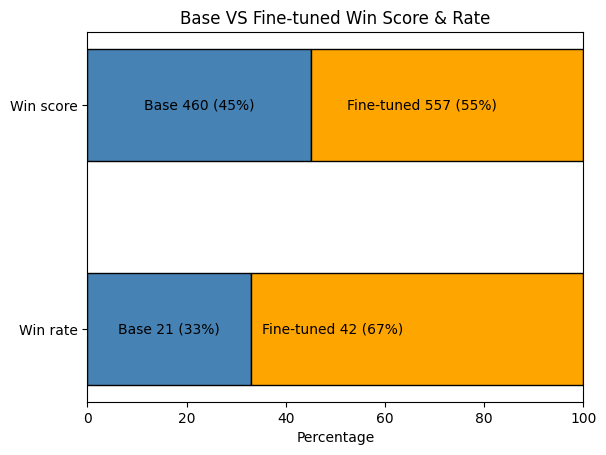

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data similar to the image
categories = ["Win rate", "Win score"]
win_rate_sum = win_results["A_wins"] + win_results["B_wins"]
win_score_sum = win_results["A_score"] + win_results["B_score"]

percentages1 = [round(win_results["A_wins"]*100/win_rate_sum), round(win_results["A_score"]*100/win_score_sum)]
percentages2 = [round(win_results["B_wins"]*100/win_rate_sum), round(win_results["B_score"]*100/win_score_sum)]
values1 = [win_results["A_wins"], win_results["A_score"]]
values2 = [win_results["B_wins"], win_results["B_score"]]

# Create a bar plot

# Bar positions
bar_width = 0.5
y_pos = range(len(categories))

# Plotting the bars
fig, ax = plt.subplots()

ax.barh(y_pos, percentages1, color='steelblue', edgecolor='black', height=bar_width)
ax.barh(y_pos, percentages2, left=percentages1, color='orange', edgecolor='black', height=bar_width)

# Adding text
for i in range(len(categories)):
    ax.text(percentages1[i]/2, i, f"Base {values1[i]} ({percentages1[i]}%)", ha='center', va='center', color='black')
    ax.text(percentages1[i] + percentages1[i]/2, i, f"Fine-tuned {values2[i]} ({percentages2[i]}%)", ha='center', va='center', color='black')

# Labels and Titles
ax.set_yticks(y_pos)
ax.set_yticklabels(categories)
ax.set_xlim(0, 100)
ax.set_xlabel('Percentage')
ax.set_title('Base VS Fine-tuned Win Score & Rate')

plt.show()
